In [ ]:
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ccxt
import time

## Transform the data

In [52]:
def transform_data():
    coins = ["btc", "eth"]
    for coin in coins:
        data = pd.read_json(f"/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data/{coin}_full_data.json")

        # Define columns
        columns = [
            "timestamp", "symbol", "type", "expiration", "time_to_mat", "coin", "strike", "opt_type", "spot",
            "bid_price", "ask_price", "mark_price", "bid_iv", "ask_iv", "mark_iv",
            "delta", "gamma", "vega", "theta", "rho", "open_interest", "volume"
        ]

        # Initialize empty list for rows
        rows = []

        # Iterate through wide-format DataFrame
        for symbol, row in data.iterrows():
            for timestamp, quote in row.items():
                if isinstance(quote, dict):  
                    entry = {col: quote.get(col, np.nan) for col in columns}
                    rows.append(entry)

        # After creating the DataFrame
        transformed_data = pd.DataFrame(rows)

        # Explicitly cast types
        transformed_data["timestamp"] = transformed_data["timestamp"].astype("int64")
        transformed_data["time_to_mat"] = (transformed_data["expiration"] - transformed_data["timestamp"]).astype("float64")
        transformed_data["DTE"] = np.floor(transformed_data["time_to_mat"] / 86400)
        transformed_data["symbol"] = transformed_data["symbol"].astype("str")
        transformed_data["type"] = transformed_data["type"].astype("str")
        transformed_data["expiration"] = transformed_data["expiration"].astype("int64")
        transformed_data["strike"] = transformed_data["strike"].astype("float")
        transformed_data["opt_type"] = transformed_data["opt_type"].astype("str")
        transformed_data["coin"] = transformed_data["coin"].astype("str")
        transformed_data["spot"] = transformed_data["spot"].astype("float")

        greek_cols = ["delta", "gamma", "vega", "theta", "rho",
                    "bid_price", "ask_price", "mark_price",
                    "bid_iv", "ask_iv", "mark_iv", "open_interest", "volume"]

        for col in greek_cols:
            transformed_data[col] = pd.to_numeric(transformed_data[col], errors="coerce")

        # Save to CSV
        transformed_data.to_csv(f"/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data/{coin}_full_data_transformed.csv", index=False)

def get_0dte():
    coins = ['btc', 'eth']
    for coin in coins:
        data = pd.read_csv(f"/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/snapshot_data/{coin}_full_data_transformed.csv")
        zero_dte = data[data["DTE"] == 0]
        zero_dte.to_csv(f"/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data/{coin}_0DTE.csv", index=False)

transform_data()
get_0dte()


KeyboardInterrupt: 

## Create spot data

In [1]:
# Initialize exchange
exchange = ccxt.binance()

# Your desired period → e.g. 1 Sep 2021 to 1 Oct 2021 (as in your ETH file)
since = exchange.parse8601('2021-09-01T00:00:00Z')
until = exchange.parse8601('2022-10-01T00:00:00Z')

# Symbol to use → ETH/USDT or BTC/USDT
symbols = ['ETH/USDT', 'BTC/USDT']

# Timeframe = 1h
timeframe = '1h'

# Max 1000 candles per call → Binance limitation
limit = 1000

# Fetch all data in loop
def fetch_all_ohlcv(symbol, timeframe, since, until):
    all_candles = []
    now = since

    while now < until:
        candles = exchange.fetch_ohlcv(symbol, timeframe, since=now, limit=limit)
        if not candles:
            break
        all_candles.extend(candles)

        # Move to next batch
        last_timestamp = candles[-1][0]
        now = last_timestamp + 1  # avoid overlap

        # Respect API rate limit
        time.sleep(exchange.rateLimit / 1000)

    df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df.set_index('timestamp', inplace=True)

    return df

# Loop over symbols and save data
for symbol in symbols:
    df = fetch_all_ohlcv(symbol, timeframe, since, until)
    print(f"\n{symbol} OHLCV sample:")
    print(df.head())

    # Save to CSV if desired:
    symbol_name = symbol.replace('/', '')
    df.to_csv(f"{symbol_name}_1h_OHLCV.csv")


NameError: name 'ccxt' is not defined

## Get plots

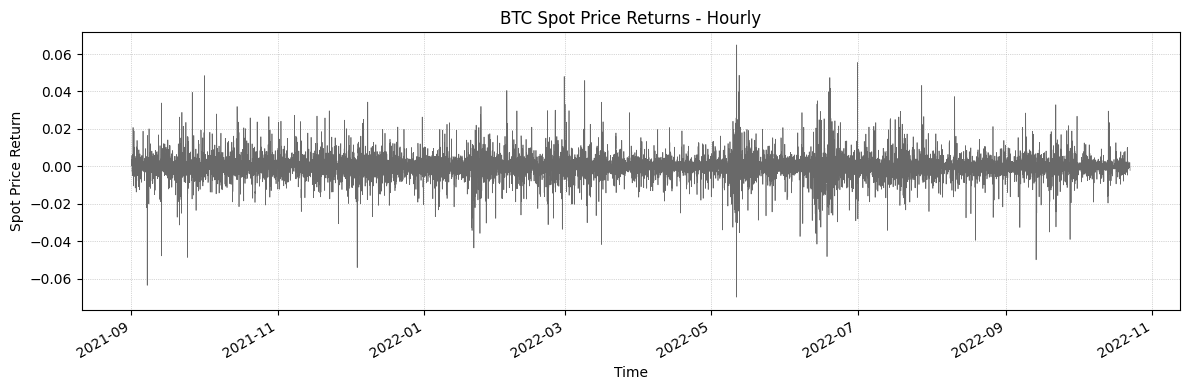

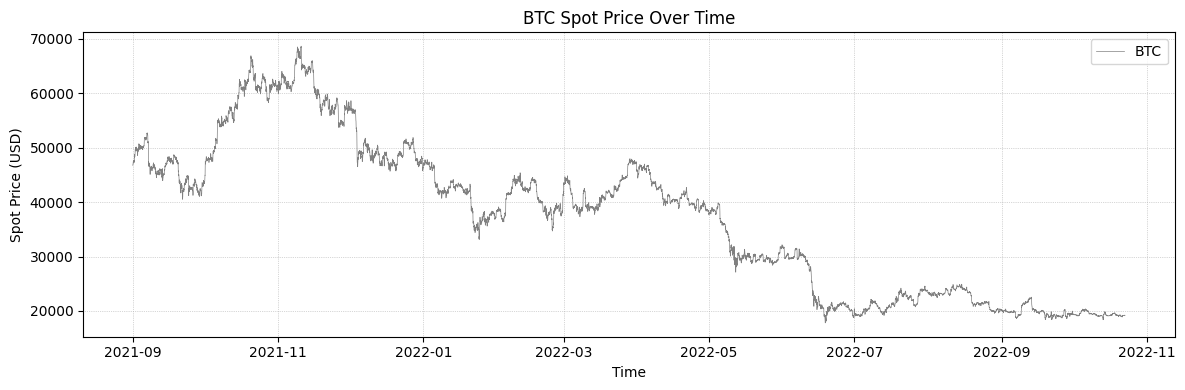

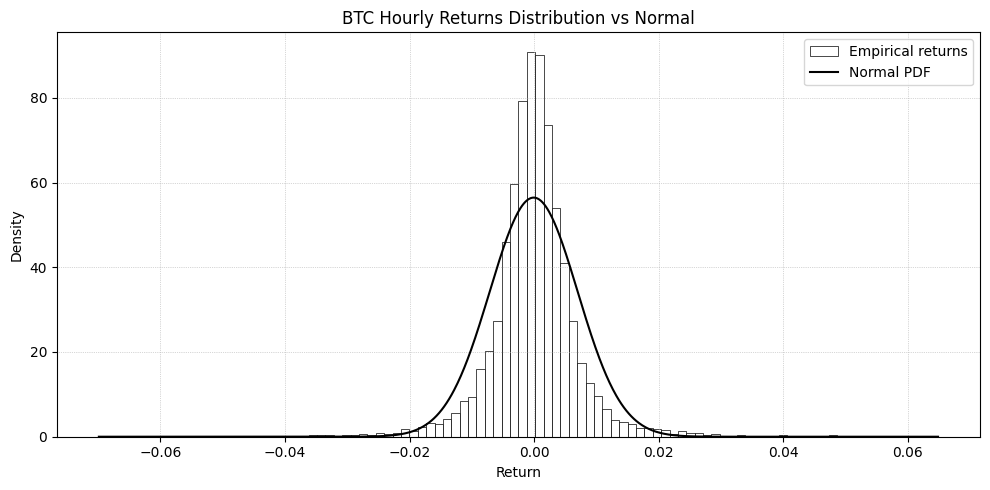

BTC Skewness: -0.09
BTC Kurtosis: 9.04 (Normal = 3)


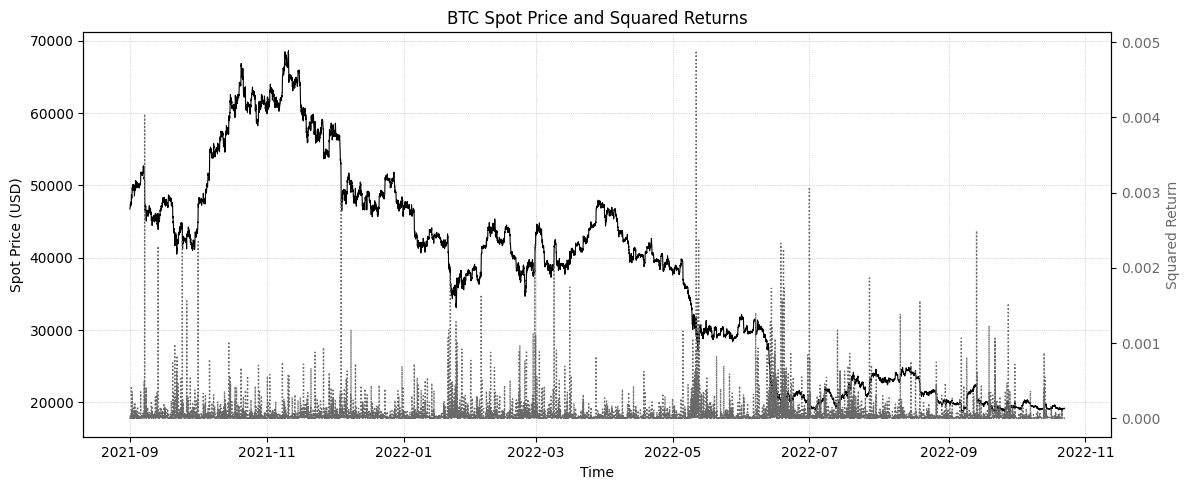

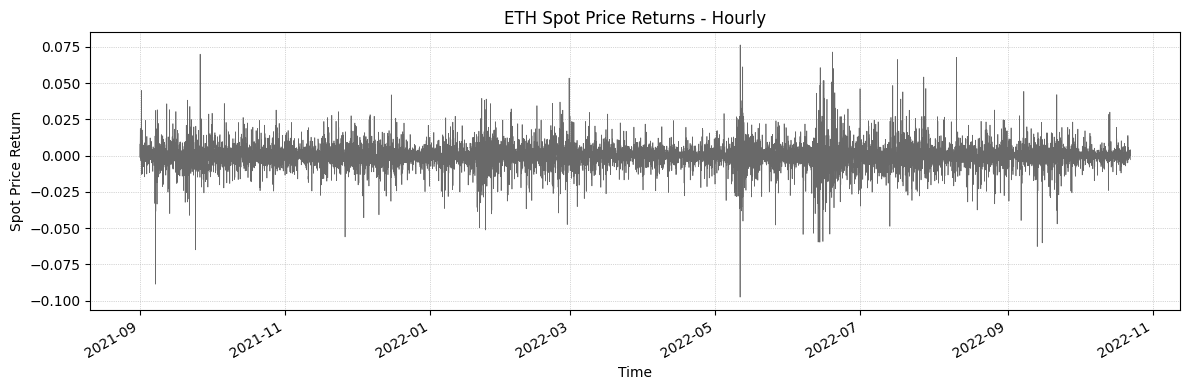

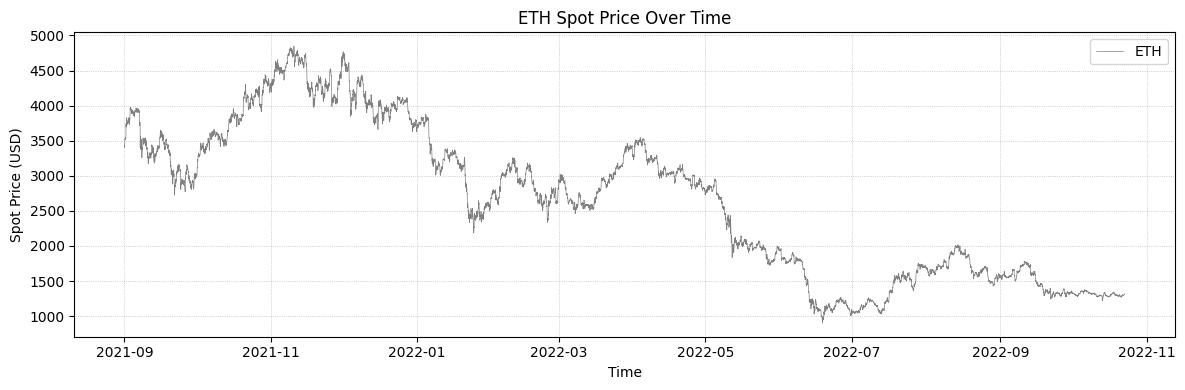

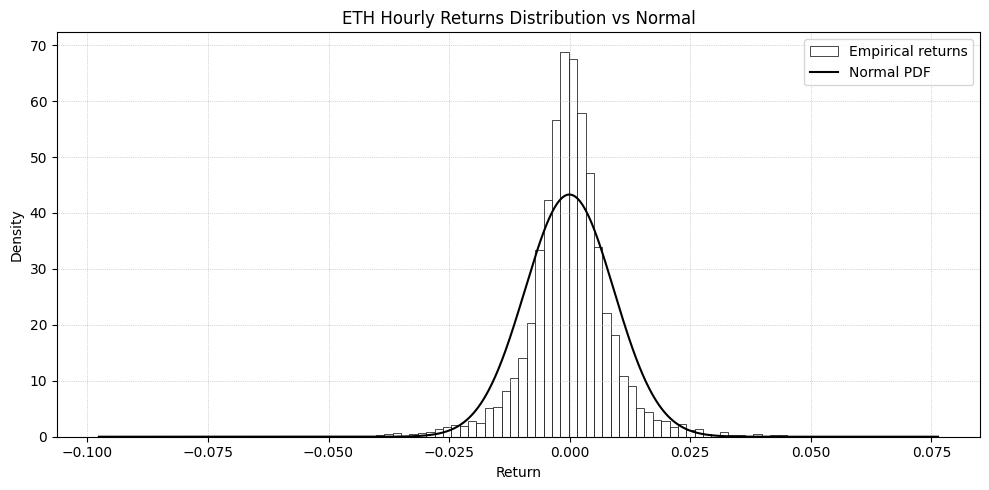

ETH Skewness: -0.14
ETH Kurtosis: 9.15 (Normal = 3)


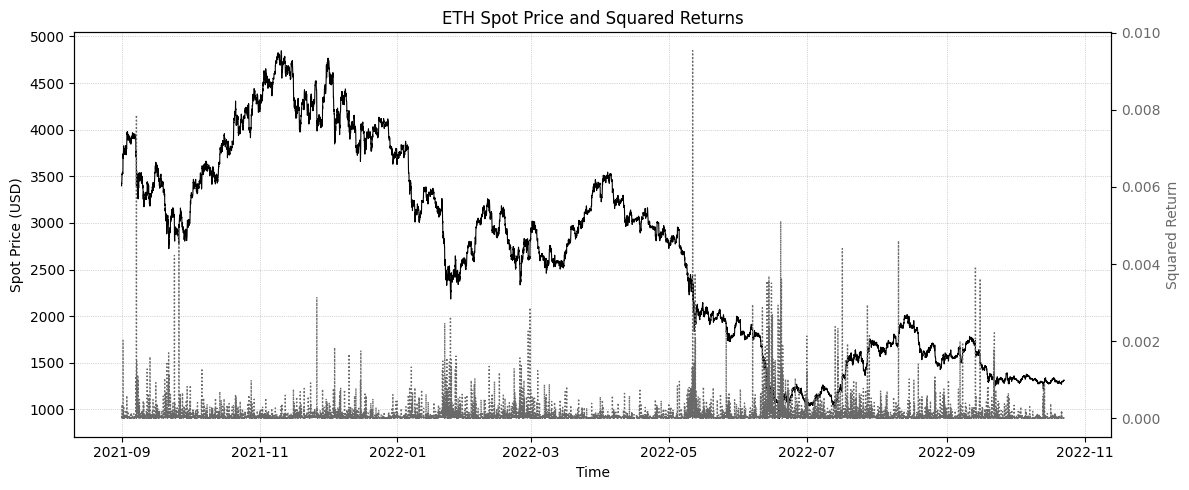

In [ ]:
coins = ['BTC', 'ETH']
for coin in coins:
    # Load OHLCV data
    df = pd.read_csv(f"/Users/joris/Documents/Master QF/Thesis/optima-gamma-hedging/Data processing/{coin}USDT_1h_OHLCV.csv")
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['log_returns'] = np.log(df['returns'])
    df = df.set_index('timestamp')

    # Use close price as spot price (standard practice)
    spot_hourly = df['close'].dropna()

    # Compute hourly returns
    spot_hourly_return = spot_hourly.pct_change().dropna()

    # Plot hourly returns
    spot_hourly_return.plot(
        figsize=(12, 4), 
        color='dimgray',  
        linewidth=0.5,
        title=f"{coin} Spot Price Returns - Hourly"
    )   
    plt.xlabel("Time")
    plt.ylabel("Spot Price Return")
    plt.grid(True, linestyle=':', linewidth=0.5)   
    plt.tight_layout()
    plt.show()
    
    # Plot spot price
    plt.figure(figsize=(12, 4))
    plt.plot(spot_hourly, label=coin, linewidth=0.5, color='gray')
    plt.title(f"{coin} Spot Price Over Time")
    plt.xlabel("Time")
    plt.ylabel("Spot Price (USD)")
    plt.grid(True, linestyle=':', linewidth=0.5)    
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Histogram vs normal
    mu = spot_hourly_return.mean()
    sigma = spot_hourly_return.std()

    plt.figure(figsize=(10, 5))
    plt.hist(
        spot_hourly_return, 
        bins=100, 
        density=True, 
        alpha=1.0, 
        color='white',   
        edgecolor='black', 
        linewidth=0.5,
        label='Empirical returns'
    )

    x = np.linspace(spot_hourly_return.min(), spot_hourly_return.max(), 1000)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color='black', lw=1.5, linestyle='-', label='Normal PDF')  

    plt.title(f"{coin} Hourly Returns Distribution vs Normal")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Skewness and kurtosis
    print(f"{coin} Skewness: {spot_hourly_return.skew():.2f}")
    print(f"{coin} Kurtosis: {spot_hourly_return.kurtosis():.2f} (Normal = 3)")

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Plot spot price on left y-axis
    ax1.plot(spot_hourly, color='black', linewidth=0.8, label='Spot Price')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Spot Price (USD)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, linestyle=':', linewidth=0.5)

    # Create second y-axis for squared returns
    ax2 = ax1.twinx()
    spot_hourly_return = spot_hourly.pct_change().dropna()
    spot_hourly_return_squared = spot_hourly_return * spot_hourly_return

    ax2.plot(spot_hourly_return_squared, color='dimgray', linestyle='dotted', linewidth=1, label='Squared Returns')
    ax2.set_ylabel('Squared Return', color='dimgray')
    ax2.tick_params(axis='y', labelcolor='dimgray')

    plt.title(f"{coin} Spot Price and Squared Returns")
    fig.tight_layout()
    plt.show()


## Get Implied Volatility Surfaces and Visualize the Skew